In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys

sys.path.append("incl/")

import ELPH_utils
import ELPH_Scaler
import ELPH_Optimizer
import ELPH_Dim_Reducer
import ELPH_VAR_Transformer

from ELPH_RDNLVAR import RDNLVAR

In [2]:
runs = ELPH_utils.load_runs(filename='../runs_rand_inits.npz')
# runs = ELPH_utils.load_runs(filename='../runs.npz')

# runs = runs[:100:1]
# for k in range(len(runs)):
#     runs[k] = runs[k][:,::2]

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

500 loaded with n_kmax = 80


runs[0] shape:  (80, 400)


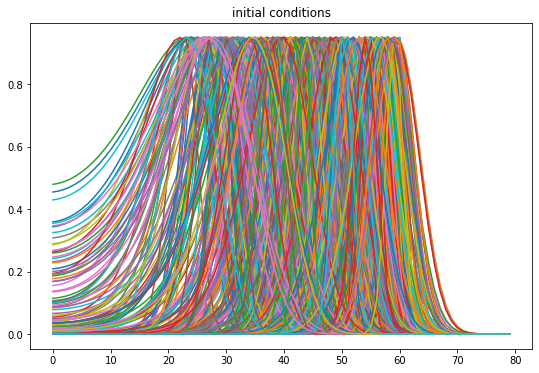

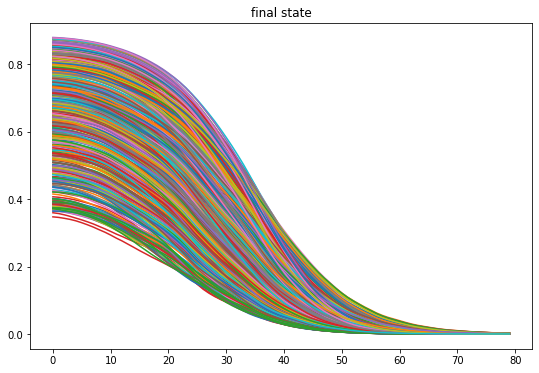

In [3]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,0])

plt.title('initial conditions')
plt.show()


for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('final state')
plt.show()

rdim:  10
prdim:  10
n_VAR_steps:  2
train shape:  (231, 199500)
target shape:  (10, 199500)
weights shape:  (231, 10)


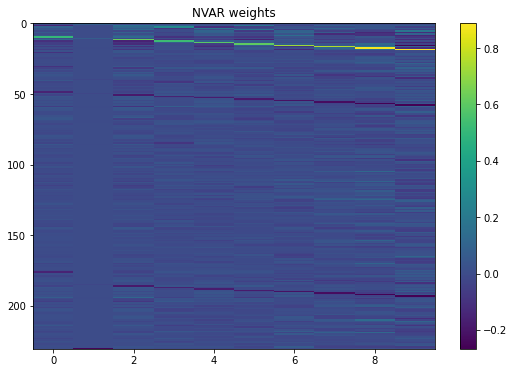

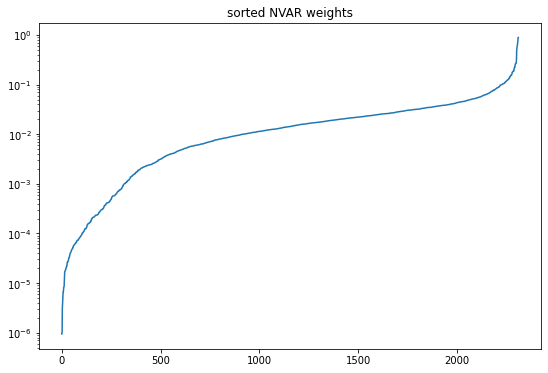

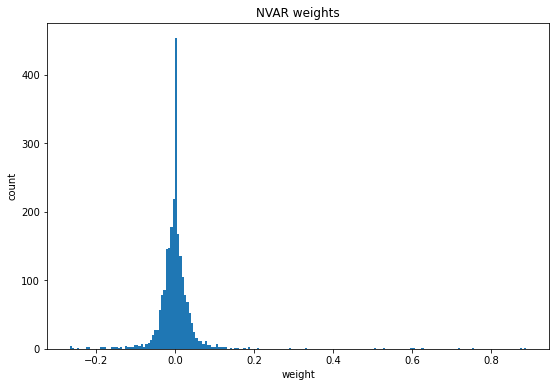

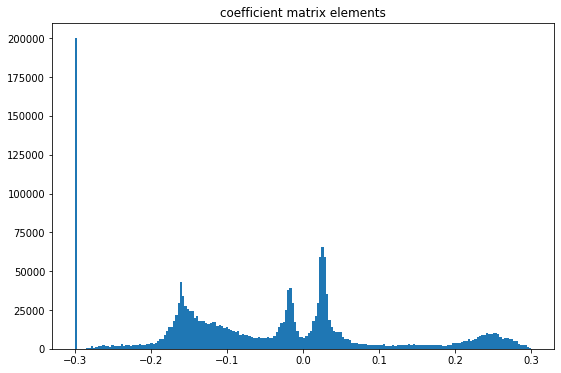

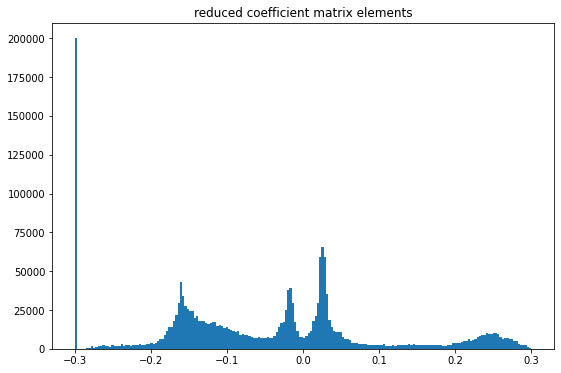

In [5]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-2)
scaler = ELPH_Scaler.normalize_scaler(0.6)
dim_reducer = ELPH_Dim_Reducer.FFT()
VAR_transformer = ELPH_VAR_Transformer.polynomial_features(order=2)

model = RDNLVAR(runs)
model.train(rdim=10, prdim = 10, n_VAR_steps=2, intercept=True, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=VAR_transformer)
model.print_status()

plt.imshow(model.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(model.w))))
plt.title('sorted NVAR weights')
plt.show()

plt.hist(np.ravel(model.w), bins=200)
plt.title('NVAR weights')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

plt.hist(np.ravel(model.coef_matrix), bins=200)
plt.title('coefficient matrix elements')
plt.show()

plt.hist(np.ravel(model.coef_matrix[:model.rdim]), bins=200)
plt.title('reduced coefficient matrix elements')
plt.show()

In [ ]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-0.5)
scaler = ELPH_Scaler.normalize_scaler(0.5)
dim_reducer = ELPH_Dim_Reducer.FFT()
VAR_transformer = ELPH_VAR_Transformer.polynomial_features(order=2)

train_kwargs = {'rdim':10, 'prdim':10, 'n_VAR_steps':2, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler, 'dim_reducer':dim_reducer, 'VAR_transformer':VAR_transformer }
score_kwargs = {'norm':'max'}


m,s = ELPH_utils.get_KFold_CV_scores(model, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)

rdim:  20
prdim:  20
n_VAR_steps:  2
train shape:  (861, 199101)
target shape:  (20, 199101)
weights shape:  (861, 20)
error:  0.2912859437831491


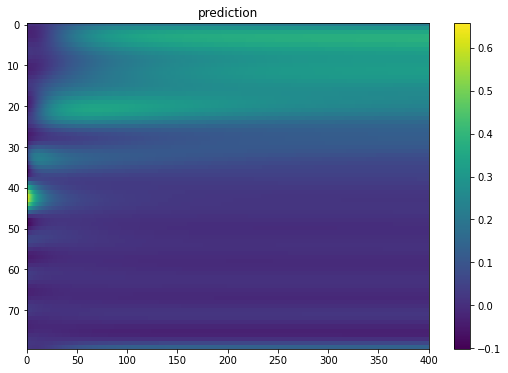

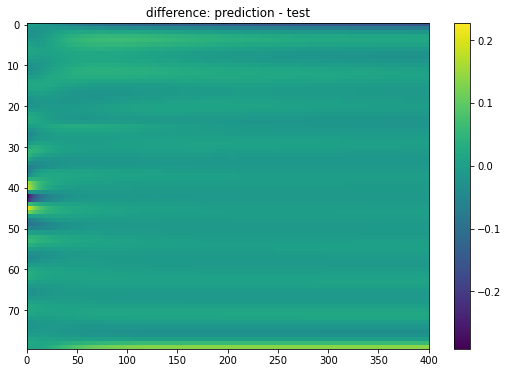

In [12]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-0.5)
scaler = ELPH_Scaler.normalize_scaler(0.5)
dim_reducer = ELPH_Dim_Reducer.FFT(sorted=False)
VAR_transformer = ELPH_VAR_Transformer.polynomial_features(order=2)

train_runs = runs[::1]
test_run = train_runs.pop(85)

model.load_runs(train_runs)
model.train(rdim=20, prdim = 20, n_VAR_steps=2, intercept=True, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=VAR_transformer)

model.print_status()


print('error: ', model.get_error(test_run, norm='max') )

pred = model.predict_single_run(test_run)

xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()


In [ ]:
colors = plt.get_cmap('inferno')

tn_arr = [0,2,5,10,20,50,100,200,399]

plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_run[:,tn], '-', c=colors(k/len(tn_arr)))
    plt.plot(pred[:,tn], '--', c=colors(k/len(tn_arr)))

plt.show()

print('std error: ', model.get_error(test_run, pred, norm='std') )
print('max abs error: ', model.get_error(test_run, pred, norm='max') )

plt.hist(np.ravel(pred-test_run), bins = 200)
plt.xlabel('error')
plt.ylabel('counts')
plt.show()

In [ ]:
dim_reducer.train(test_run)
reduced_run = dim_reducer.reduce(test_run, 60)
approx_run = dim_reducer.expand(reduced_run)

plt.imshow(test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('test')
plt.show()

plt.imshow(approx_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('approx')
plt.show()

plt.imshow(test_run-approx_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('test - approx')
plt.show()